# MARS3888 - Finding and Using Online Datasets 

## Notebook 1


+ Part A: Read the contents of a NetCDF file
+ Part B: Plot Data
    + Plot a simple map using data
    + Plot sea surface currents with an overlay using Quiver


#### Load the required Python libraries

First of all, load the necessary libraries:

+ numpy
+ matplotlib
+ cartopy
+ xarray
+ cmocean

In [3]:
import os
import numpy as np
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Part A: Read the contents of a NetCDF file

In this example, we will start exporting eReefs data using the `Xarray` and `open_dataset` function to open a netCDF file into a xarray Dataset called `ds`.

We will query load the eReefs GBR4km dataset from the [AIMS server](http://thredds.ereefs.aims.gov.au/thredds/catalog.html), so let's first define the base URL:

In [4]:
url="https://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/monthly-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_monthly-monthly-2010-09.nc"
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:      (time: 1, k: 17, latitude: 723, longitude: 491)
Coordinates:
    zc           (k) float64 ...
  * time         (time) datetime64[ns] 2010-08-31T14:00:00
  * latitude     (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude    (longitude) float64 142.2 142.2 142.2 ... 156.8 156.8 156.9
Dimensions without coordinates: k
Data variables:
    salt         (time, k, latitude, longitude) float32 ...
    temp         (time, k, latitude, longitude) float32 ...
    u            (time, k, latitude, longitude) float32 ...
    v            (time, k, latitude, longitude) float32 ...
    mean_cur     (time, k, latitude, longitude) float32 ...
    eta          (time, latitude, longitude) float32 ...
    wspeed_u     (time, latitude, longitude) float32 ...
    wspeed_v     (time, latitude, longitude) float32 ...
    mean_wspeed  (time, latitude, longitude) float32 ...
Attributes: (12/22)
    Conventions:                     CF-1.0
    Run_ID:                          2
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2023-01-25T15:16:32+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__gbr4_v2__...
    aims_ncaggregate_firstDate:      2010-09-01T00:00:00+10:00
    ...                              ...
    prefix_list_qudt__:              http://qudt.org/vocab/unit/
    shoc_version:                    v1.1 rev(5320M)
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 m...
    DODS_EXTRA.Unlimited_Dimension:  time

The netcdf above contains coordinates (zx, time, latitude and longitude) and mean variables (mean_current, temp, sea surface height) for month.

Now lets plot some temperature data from the netcdf we just loaded

# Part B: Plot netcdf Data as a Map

## Simple Plot

Now using the above NetCDF data we will look at temperature for the GBR with a Marker at the location of One Tree Island defined by these coodinates:

In [5]:
reef_lat = -23.508
reef_lon = 152.091

Run this next section of code to plot the data:

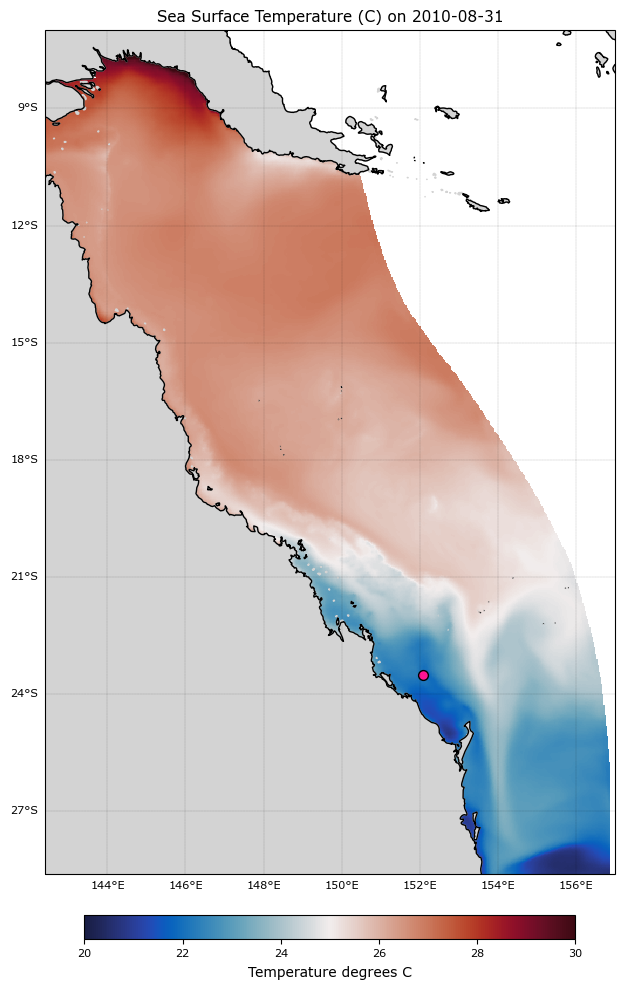

<Figure size 640x480 with 0 Axes>

In [36]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the Temp at the surface at the final recorded time interval
cf = ds.temp.isel(time=-1,k=-1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 20, vmax = 30,
    add_colorbar=False
)

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds.temp.long_name+' '+ds.temp.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Sea Surface Temperature (C) on ' +str(ds.coords['time'].values[-1])[:10],
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))

ax.coastlines(linewidth=1)

# Site One Tree Island
ax.scatter(reef_lon, reef_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

## Clip the Dataset and Plot Again
To reduce the Dataset size we will clip the spatial extent based on longitudinal and latitudinal values.

This is easely done using the sel function with the slice method:

In [7]:
min_lon = 150     # lower left longitude
min_lat = -27     # lower left latitude
max_lon = 155     # upper right longitude
max_lat = -20     # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# Performing the reduction
ds_clip = ds.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))

Let’s plot the clipped data using the same approach as above:

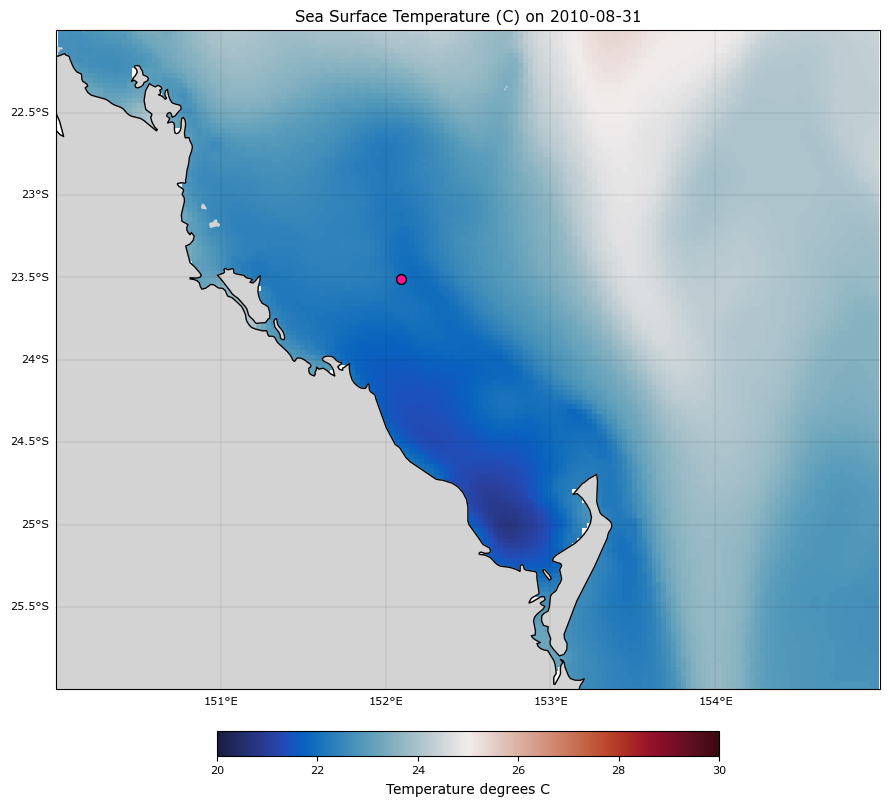

<Figure size 640x480 with 0 Axes>

In [8]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([150, 155, -22, -26], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = ds_clip.temp.isel(time=-1,k=-1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 20, vmax = 30,
    add_colorbar=False
)

# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds_clip.temp.long_name+' '+ds_clip.temp.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Sea Surface Temperature (C) on ' +str(ds_clip.coords['time'].values[-1])[:10],
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))

ax.coastlines(linewidth=1)

# Site One Tree Island
ax.scatter(reef_lon, reef_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

# Plot sea surface currents with an overlay using Quiver

To make the quiver plot, we will first resample the Dataset and take one point every 7 times. It allows to have less arrows on the map making it more readable.

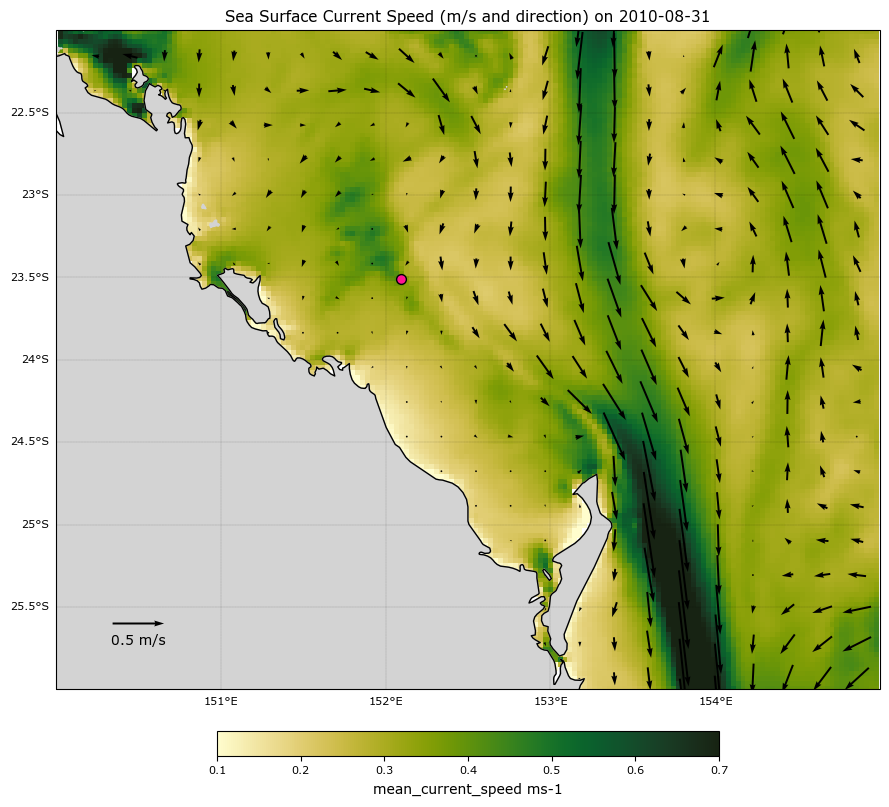

<Figure size 640x480 with 0 Axes>

In [37]:
# Figure size
size = (9, 10)

# Time step to plot
timevar = 0

# z-coordinate position (here the top one)
zcvar = -1

# extent (OTI focus)
min_lon = 150     # lower left longitude
min_lat = -26     # lower left latitude
max_lon = 155     # upper right longitude
max_lat = -22     # upper right latitude

# Color from cmocean
color = cmocean.cm.speed

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', 
                 edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], 
              ccrs.PlateCarree())

# Plotting using Matplotlib the mean current
cf = ds_clip.mean_cur.isel(time=timevar,k=zcvar).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0.1, vmax = 0.7,
    add_colorbar=False
)

# Resampling using the slice method
resample = ds_clip.isel(time=timevar,k=zcvar,longitude=slice(None, None, 7),
                              latitude=slice(None, None, 7))

# Defining the quiver plot
quiver = resample.plot.quiver(x='longitude', y='latitude', u='u', v='v', 
                              transform=ccrs.PlateCarree(), scale=8)      

# Vector options declaration
veclenght = 0.5
maxstr = '%3.1f m/s' % veclenght
plt.quiverkey(quiver,0.1,0.1,veclenght,maxstr,labelpos='S', 
              coordinates='axes').set_zorder(11)


# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds_clip.mean_cur.long_name+' '+
               ds_clip.mean_cur.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Sea Surface Current Speed (m/s and direction) on '+
          str(ds_clip.mean_cur.coords['time'].values[timevar])[:10],
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Site One Tree Reef
ax.scatter(reef_lon, reef_lat, c='deeppink', s=50, edgecolors='k', 
           linewidth=1, transform=ccrs.PlateCarree()).set_zorder(11)

plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

### End of Notebook 1

Now you know the basics of reading and plotting a NetCDF file.